## DERIVATIVE PRICING
MODULE 4 | LESSON 3


---



# **BLACK-SCHOLES AND MONTE CARLO METHODS**


|  |  |
|:---|:---|
|**Reading Time** |  55 minutes |
|**Prior Knowledge** | Black-Scholes, GBM, Monte-Carlo  |
|**Keywords** | Monte-Carlo, Black-Scholes, Simulation, Convergence between methods |


---

*In this lesson, we will expand our knowledge of the Black-Scholes framework by considering a Monte Carlo approach to pricing options under an SDE. Specifically, we will verify that Monte Carlo methods applied on the appropriate SDE converge with the analytical Black-Scholes model price.*

As always, let's first import some libraries we will need down the road:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import numpy.random as npr
from scipy.stats import norm

## 1. Monte Carlo Method

An alternative way to compute the call option price is to use Monte Carlo methods. This, obviously, makes little sense now (we do have a closed-form solution, right?), but it will come in handy when we move to more complex frameworks. The starting point is taking the Brownian motion equation for the underlying stock, $S_t$, in the risk-neutral world:

$$dS = S\,r dt +S\sigma dz\,$$

This equation can be discretized by a Euler scheme. By doing this, we obtain the stock price at a future date given by:<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

$$S_{T} = S_{t} e^{\left(\left(r-\frac{1}{2}\sigma^{2}\right)(T-t) +\sigma \sqrt{T-t}\,z\right)}\,,$$

where $z$ is a stochastic variable following $\mathcal{N}(0,1)$.

We can simulate the process above using the Monte Carlo method. As an example, we set $r=0.06$, $\sigma=0.3$, $T-t=1$, $S_t=100$. We make $I=100000$ iterations and choose $M=100$ intervals for the time interval discretization:

In [2]:
r = 0.06
sigma = 0.3
T = 1.0
S0 = 100

Ite = 100000
M = 100

dt = T / M

S = np.zeros((M + 1, Ite))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(Ite)
    )

Now, we have the simulated values for stock prices, $S_t$. According to the theoretical setting, these prices should follow a log-normal distribution. Let's check and see.

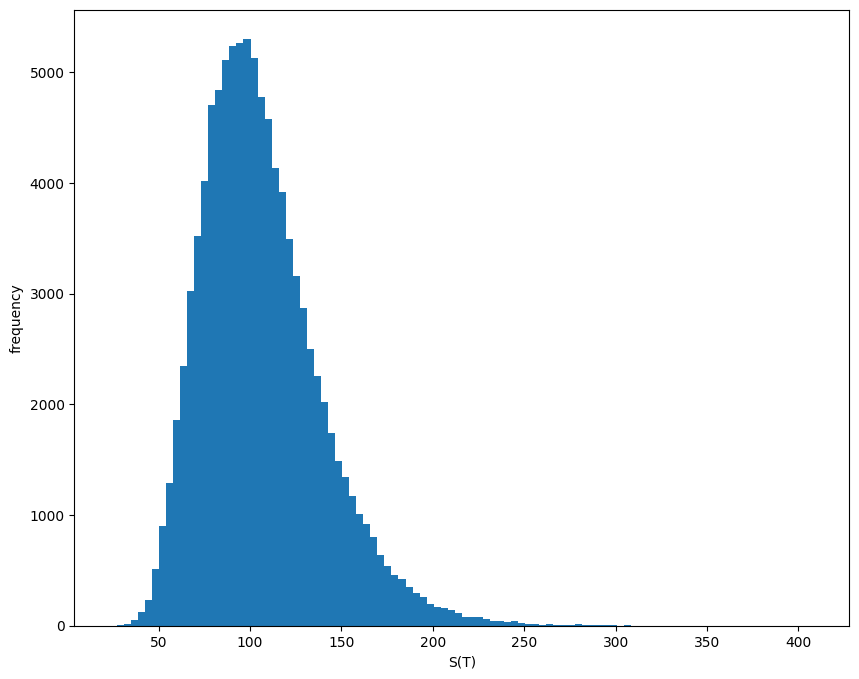

In [3]:
plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel("S(T)")
plt.ylabel("frequency")
plt.show()

Yes! $S_t$ follows a log-normal distribution. Let's also visualize a few of the simulated paths under the previous parameters to get a feeling of how stock prices move in each path:

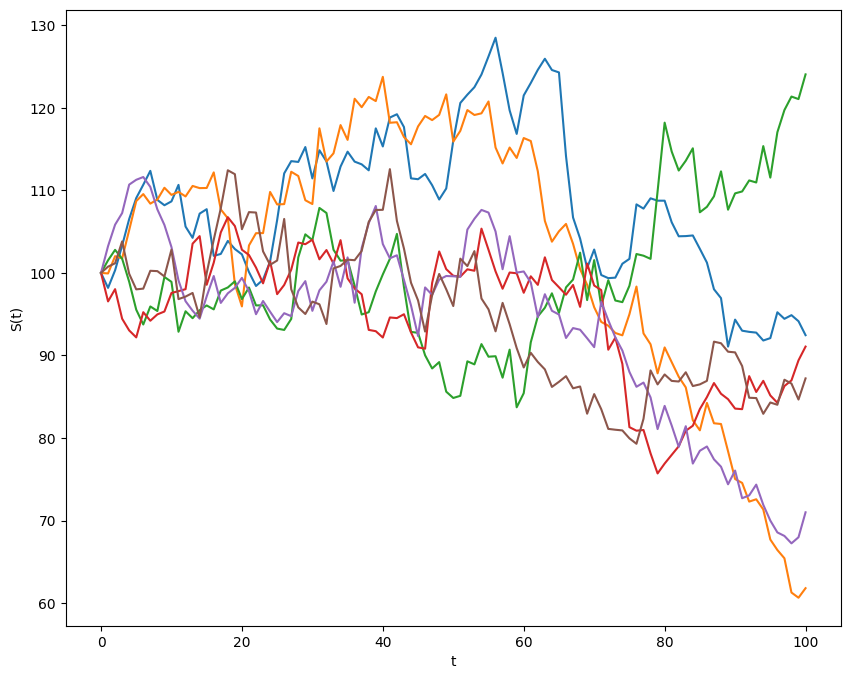

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(S[:, :6])
plt.xlabel("t")
plt.ylabel("S(t)")
plt.show()

Now, it is time to implement our Monte Carlo algorithm. We will construct a function, `bs_call_mc`, that calculates the price, according to the Monte Carlo method, of a European call option. Remember the steps we are doing in the code below:

- Simulate stock price paths according to SDE dynamics.
- Calculate the terminal option payoff for each path.
- Obtain the average expected payoff at maturity, T.
- Discount the average expected payoff to time t.

In [5]:
def bs_call_mc(S, K, r, sigma, T, t, Ite):
    data = np.zeros((Ite, 2))
    z = np.random.normal(0, 1, [1, Ite])
    ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
    data[:, 1] = ST - K

    average = np.sum(np.amax(data, axis=1)) / float(Ite)

    return np.exp(-r * (T - t)) * average

Let's see the pricing power of the previous function with a European call option with the following characteristics:

- $S_0=100$
- $K=95$
- $r=0.06$
- $\sigma = 0.3$
- $T = 1$ year
- $t = 0$ (present day)
- Number of iterations $I=100000$

In [6]:
print("Monte Carlo Price:", bs_call_mc(100, 95, 0.06, 0.3, 1, 0, 100000))

Monte Carlo Price: 17.223189357223834


## 2. Convergence of Monte Carlo to Black-Scholes

Next, let's check the price that our analytical pricing formula (the one we implemented in the last lesson) yields.

In [7]:
def bs_call_price(S, r, sigma, t, T, K):
    ttm = T - t

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        return np.maximum(S - K, 0.0)

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    d_plus = d_minus + vol

    res = S * norm.cdf(d_plus)
    res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)

    return res

In [8]:
print("BS Analytical Price:", bs_call_price(100, 0.06, 0.3, 0, 1, 95))

BS Analytical Price: 17.323563283257634


We observe that the Monte Carlo price (17.42) is actually very close to the Black-Scholes analytical price (17.32). As usual, the convergence to the true analytical price will depend on the number of simulations. Thus, once again, we face the trade-off between computational costs and accuracy.

Next, let's explore how quickly (or slowly) Monte Carlo estimates converge with Black-Scholes analytical prices:

/tmp/ipykernel_18/2310393175.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(


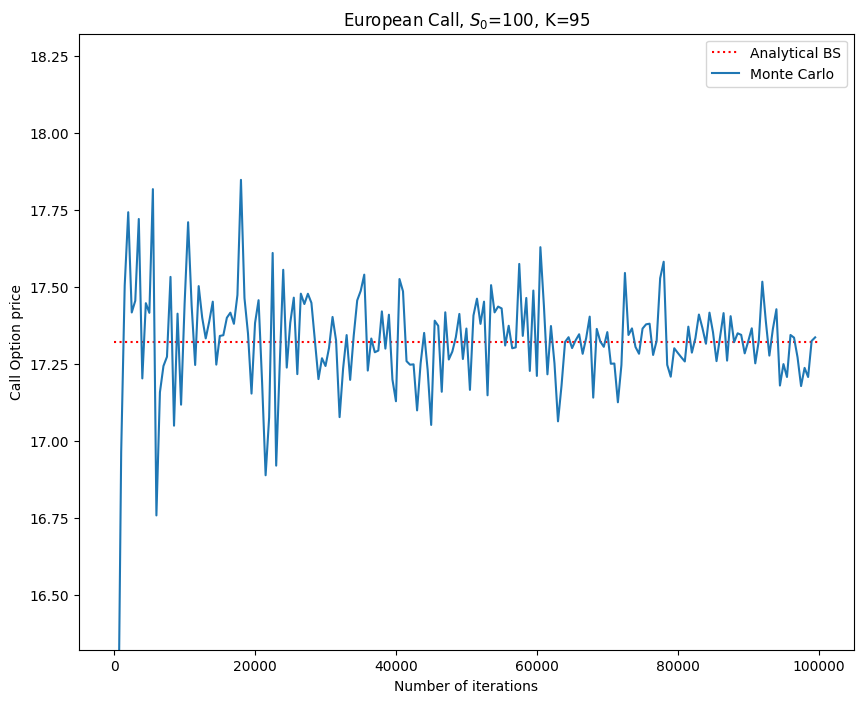

In [9]:
df = pd.DataFrame(columns=["Iter", "BSc"])
 
for i in range(1, 100000, 500):
    df = pd.concat([df, pd.DataFrame(
    [{"Iter": i, "BSc": bs_call_mc(100,95,0.06,0.3,1,0,i)}])], ignore_index=True
    )

plt.figure(figsize=(10, 8))

plt.hlines(
    bs_call_price(100, 0.06, 0.3, 0, 1, 95),
    xmin=0,
    xmax=100000,
    linestyle="dotted",
    colors="red",
    label="Analytical BS",
)
plt.plot(df.set_index("Iter"), lw=1.5, label="Monte Carlo")

plt.title("European Call, $S_0$=100, K=95")
plt.xlabel("Number of iterations")
plt.ylabel("Call Option price")
plt.ylim(
    bs_call_price(100, 0.06, 0.3, 0, 1, 95) - 1,
    bs_call_price(100, 0.06, 0.3, 0, 1, 95) + 1,
)
plt.legend()
plt.show()

Can you do the same thing for a put option?


## 3. Conclusion

Now you know how to implement Monte Carlo methods for the simulation of underlying stock price evaluation in the Black-Scholes world. In the next lesson, we will see that Monte Carlo methods are useful for simulating not only stock prices but also other kinds of assets (such as interest rates) given the appropriate model dynamics.

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
